In [12]:
# z-test for two-sample proportion test
# https://www.hellovaia.com/explanations/math/statistics/confidence-intervals/
import math
from scipy import stats
import pandas as pd

n1, f1, n2, f2 = 19351, 160, 19187, 136  # x1 = exp, x2: base
prac_thres_rel = 0.05                    #相对基准起码提升5%/降低-5%，才认为业务能感知
alpha = 0.15                             #统计意义显著

p1 = f1/n1
p2 = f2/n2
var1 = p1*(1-p1)/n1
var2 = p2*(1-p2)/n2
pool_standard_error = math.sqrt(var1 + var2)

# 统计量和P值
center = p1 - p2
z_statistic = center/pool_standard_error
p_value = stats.norm.sf(abs(z_statistic))

# 方法一：theory based method，置信区间公式: x +- z(0.05) * SE，SE用估计方法得到
z_score_thres = stats.norm.isf(alpha/2) #双边检测, zscore = 1.96 when alpha = 0.05
margin_error = z_score_thres * pool_standard_error
conf_interval = (center - margin_error, center + margin_error)

# 除以base数据，得到相对提升
center_rel = round(center/p2, 6)
conf_interval_rel = list(map(lambda x: round(x/p2, 6), conf_interval))

# 是否统计意义上置信，置信区间要同号
statistic_conf = True if conf_interval_rel[0] * conf_interval_rel[1] > 0 else False

# 是否实际意义上置信，正向置信时，下界大于实际业务感知阈值；负向置信时，上界小于负的实际业务感知阈值
if statistic_conf and conf_interval_rel[0] > 0:
    pratically_conf = True if conf_interval_rel[0] > prac_thres_rel else False
    final_result = '正'
elif statistic_conf and conf_interval_rel[0] < 0:
    pratically_conf = True if conf_interval_rel[1] < -1 * prac_thres_rel else False
    final_result = '负'
else:
    pratically_conf = False
    final_result = 'NA'


pd.DataFrame({
    "type": "two_sample_prop",
    "mean_treat": p1,
    "mean_ctrl": p2,
    "var_treat" : var1,
    "var_ctrl" : var2,
    "diff": center,
    "z_stat": z_statistic, 
    "p_value" : p_value, 
    "lower": conf_interval[0],
    "upper": conf_interval[1],
    "ratio_lower": conf_interval_rel[0],
    "ratio_upper": conf_interval_rel[1],
    "统计显著": statistic_conf,
    "业务显著": pratically_conf,
    "统计显著方向": final_result},index=[0])

,type,mean_treat,mean_ctrl,var_treat,var_ctrl,diff,z_stat,p_value,lower,upper,ratio_lower,ratio_upper,统计显著,业务显著,统计显著方向
0,two_sample_prop,0.008268,0.007088,4.237477e-07,3.668052e-07,0.00118,1.327335,0.092199,-0.0001,0.00246,-0.014074,0.347074,False,False,NA


In [3]:
# https://medium.com/@ahmadnuraziz3/applying-delta-method-for-a-b-tests-analysis-8b1d13411c22
import pandas as pd
import numpy as np
from random import randint
from scipy import stats 

treatment = pd.read_csv("/Users/yili.tyl/Downloads/exp_5.csv")
control = pd.read_csv("/Users/yili.tyl/Downloads/base_5.csv")

#variance estimation of metrics ratio
def var_ratio(x,y): #x/y
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x,ddof=1)
    var_y = np.var(y,ddof=1)
    cov_xy = np.cov(x,y,ddof=1)[0][1]
    result = (var_x/mean_x**2 + var_y/mean_y**2 - 2*cov_xy/(mean_x*mean_y))*(mean_x*mean_x)/(mean_y*mean_y*len(x))
    return result
    
#ttest calculation 
def ttest(mean_control,mean_treatment,var_control,var_treatment):
    diff = mean_treatment - mean_control
    var = var_control+var_treatment
    stde = 1.96*np.sqrt(var)
    lower = diff - stde 
    upper = diff + stde
    z = diff/np.sqrt(var)
    # p_val = stats.norm.sf(abs(z)) * 2
    p_val = stats.norm.sf(abs(z))

    result = {
             "type": "ctr_variance",
             'mean_treat':mean_treatment,
             'mean_ctrl':mean_control,
             'var_treat':var_treatment,
             'var_ctrl':var_control,
             'diff':diff,
             "z_stat": z, 
             'p_value':p_val,
             'lower':lower,
             'upper':upper,
             'ratio_lower':lower/mean_control,
             'ratio_upper':upper/mean_control}
    return pd.DataFrame(result,index=[0])

var_control = var_ratio(control['click'],control['view'])
var_treatment = var_ratio(treatment['click'],treatment['view'])
mean_control = control['click'].sum()/control['view'].sum()
mean_treatment = treatment['click'].sum()/treatment['view'].sum()

ttest(mean_control,mean_treatment,var_control,var_treatment)

,type,mean_treat,mean_ctrl,var_treat,var_ctrl,diff,z_stat,p_value,lower,upper,ratio_lower,ratio_upper
0,ctr_variance,0.008268,0.007088,4.237531e-07,3.666682e-07,0.00118,1.327445,0.092181,-0.000562,0.002923,-0.079341,0.412341


In [8]:
ctr_c_list = []
ctr_t_list = []
ctr_diff = []
ctr_ratio = []
for i in range(10000):
    new_treatment = treatment.sample(n=treatment.shape[0], replace=True).sum()
    new_control = control.sample(n=control.shape[0], replace=True).sum()
    #print(new_treatment)
    ctr_t = new_treatment[2] / new_treatment[3]
    ctr_c = new_control[2] / new_control[3]
    diff = ctr_t - ctr_c
    rate = diff / (ctr_c + 1e-10)
    ctr_diff.append(diff)
    ctr_ratio.append(rate)
    ctr_c_list.append(ctr_c)
    ctr_t_list.append(ctr_t)


,type,mean_treat,mean_ctrl,var_treat,var_ctrl,diff,z_stat,p_value,lower,upper,ratio_lower,ratio_upper
0,bootstrap,0.008262,0.007093,0.000656,0.000602,0.001169,None,0.0954,-0.000591,0.002929,-0.083334,0.412991


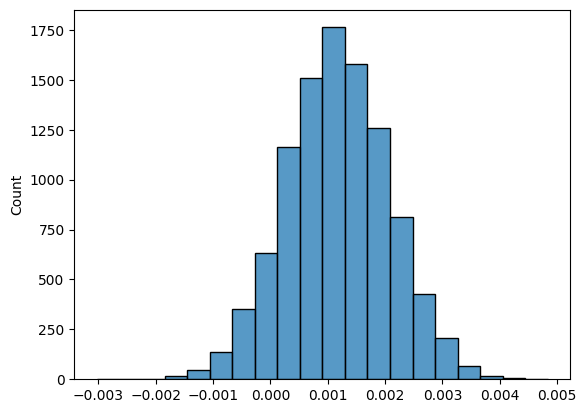

In [9]:
import seaborn as sns
from scipy import stats

sns.histplot(ctr_diff, bins=20, kde=False)
pd.DataFrame({
    "type": "bootstrap",
    "mean_treat": np.mean(ctr_t_list),
    "mean_ctrl": np.mean(ctr_c_list),
    "var_treat": np.std(ctr_t_list, ddof=1),
    "var_ctrl": np.std(ctr_c_list, ddof=1),
    "diff": np.mean(ctr_diff),
    "z_stat" : None,
    "p_value" : 1 - len([x for x in ctr_diff if x > 0])/len(ctr_diff),
    "lower": np.mean(ctr_diff) - stats.norm.isf(0.05/2) * np.std(ctr_diff, ddof=1),
    "upper": np.mean(ctr_diff) + stats.norm.isf(0.05/2) * np.std(ctr_diff, ddof=1),
    #"lower_1": np.quantile(ctr_diff, 0.025),
    #"upper_1": np.quantile(ctr_diff, 0.975),
    "ratio_lower": ( np.mean(ctr_diff) - stats.norm.isf(0.05/2) * np.std(ctr_diff, ddof=1) ) / np.mean(ctr_c_list),
    "ratio_upper": (np.mean(ctr_diff) + stats.norm.isf(0.05/2) * np.std(ctr_diff, ddof=1)) /  np.mean(ctr_c_list)
},index=[0])